# Coins in a bag: Bayesian updating/inference

### Aims of this notebook:
1. Write out the mathematics for conditional probability and then elevating this to a Bayesian view of things
2. Add in the likelihood to the `CoinFlip` class (is there a better way to define `nCr` (i.e. use an existing `scipy` function)
3. Add in fucntionality to update multiple times and show that this gives the same results as before
4. Show that we can use a non-uniform prior to show a belief and show how convergence time changes when we are sure and when we are unsure
5. look at a cosomological model (or any other two parameter system)

### Notebook structure:
1. Conditional probabilities and Bayes' rule
2. Elevating to probability distributions
3. Generalising to a 100-coin bag
4. Bayesian updating
5. Non-uniform priors

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import timeit
import random

## 1. Conditional proabilities and Bayes' rule

For this notebook, we assume that you are familiar with Bayes' rule for [conditional probabilities](https://en.wikipedia.org/wiki/Conditional_probability):

$$P(A|B) =  \frac{P(B|A) P(A)}{P(B)} $$

Lets apply this equation to an example where we have a bag with two coins, one is a fair coin and the other has a heads on both sides. We pick one coin out of the bag at random and flip it twice and get HH. Using conditional probabilities and Bayes' rule we can update our probabilities of which coin we might have (which before the flips is 50/50). Therefore Bayes' rule becomes:

$$P(B|HH) =  \frac{P(HH|B) P(B)}{P(HH)} $$

$P(HH|B) = 1$ as the doubled-headed coin can only flips heads

$P(B) = 0.5$ before flipping we pick one of two coins with equal probability

$P(HH) = 0.5 \cdot 1^2 + 0.5 \cdot 0.5^2 = 0.375$

$$P(B|HH) =  \frac{P(HH|B) P(B)}{P(HH)} = \frac{1 \cdot 0.5}{0.625} = 0.8$$

![PMF_Two_Coins](figs/pmf_twocoins.png)

## 2. Elevating to probability distributions

We can now try and look at the same problem through the lens of probability distributions, to do this we need to define the prior, likelihood and posterior. 

### Prior, $\pi (\theta)$
The prior distribution is a probability distribution of our prior beliefs of the parameters of the system before we've seen any data. 

In the case of our two coins in a bag, the parameter of the model $\theta$ is the *bias* of the coin we picked, $p$. Before actually flipping the coin, we believe there is an equal chance that we picked a coin with $p=0.5$ or $p=1$. This is known as a *uniform prior* as the probability distribution over the values of parameters in the model is uniform. We will look later at non-uniform priors and when to use them.

### Likelihood, $\mathcal L(D | \theta)$
The likelihood describes how likely we are to observe some data, given the parameters of the model.

In our case where we are flipping coins we notice that each flip has just two outcomes and therefore many flips will follow a [binomial distribution](#), having the formula for this binomial distribution becomes necessary for more non-trivial cases (i.e. $>2$ flips).

### Posterior, $P(\theta | D)$
The posterior is the probability distribution over the model paramters which we get after updating the prior using our data


This gives us an analogous expression for Bayes' rule for distributions:

$$P(\theta | D) = \frac{\mathcal L(D | \theta) \cdot \pi(\theta) }{ P(D)}$$

N.B all distributions in our case theta domain $[0,1]$ and therefore we can multiply two distributions together by multiplying elementwise (this how `numpy` works out of the box). Distributions are vectors and not continuous

### Exercise: Constructing the Likelihood, $\mathcal L(D | \theta)$

The likelihood, $\mathcal L (D_N | p)$ for a coin with bias $p$ is the probability of seeing a given outcome of $N$ coin flips, this follows a binomial distribution. 

Fill in your code for the function definition below using the type hints of the inputs and outputs along with the form of `data` as given in the previous cell

In [2]:
def likelihood(data: np.array(bool), p: np.array(float)) -> np.array(float):
    '''
    YOUR CODE HERE!

    Hint: use `math.comb()`
    '''
    heads = np.sum(data)
    n = len(data)
    tails = n - heads
    prob = math.comb(n,heads)*(p**heads)*((1-p)**tails)
    return prob

In [3]:
assert likelihood(data=[True, True], p=0.5) == 0.25
assert likelihood(data=[True, True, False], p=0.5) == 3/8
assert likelihood(data=[True], p=0) == 0

### Exercise: Constructing the Posterior, $P( \theta | D)$

Now use the your likelihood function in Bayes' rule to calculate the posterior. Note how we didn't define $P(D)$ earlier, this is becuase we use it as a normalising factor, though this term is known as the *model evidence* which has many subtleties that go beyond the scope of this tutorial. Therefore, for now, we always want our posteriors (and priors) to be normalised ($\sum_i P(p_i | D) = 1$).

When generating a posterior for a given coin flip data, we can run a couple of sense checks on the results. If we see a single TAILS in the data, then our probability of having the $p=1$ coin is 0. We should also check that the probabilities calculated by hand in (Ex.A) agree with the program.

Fill out the function definitions below using the again using type hints

if you construct a function using existing vectorised `numpy` functions, and the operations within that function are element-wise, your new function will also be vectorised (this is the likelihood)

In [4]:
def posterior(data: np.array(bool), theta: float, prior: np.array(float)) -> np.array(float):
    '''
    YOUR CODE HERE!

    Hint: 
    this is possible with `numpy` vectorisation (i.e. no loops) 

    as `likelihood()` acts on single elements it is also vectorised

    if vectorisation is unfamiliar try with loops first
    '''
    
    '''
    D = 0
    outputs = []
    for t in range(len(theta)):
        D += likelihood(data,theta[t])*prior[t]
    for t in range(len(theta)):
        outputs.append(likelihood(data,theta[t])*prior[t]/D)
    return outputs
    
    '''
    likelihoods = np.array([likelihood(data,t) for t in theta])
    products = likelihoods*prior
    D = np.sum(products)
    outputs = products/D
    return outputs
    
    

In [5]:
assert np.allclose(
    posterior(data=np.array([True, True]), theta=np.array([0.5,1]), prior=np.array([0.5,0.5])),
    np.array([0.2,0.8])
)

assert np.allclose(
    posterior(data=np.array([True, False]), theta=np.array([0,0.5, 1]), prior=np.array([1/3,1/3,1/3])), 
    np.array([0,1,0])
)

assert np.allclose(
    posterior(data=np.array([True, True]), theta=np.array([0,0.25,0.5,0.75,1]), prior=np.array([0.2,0.2,0.2,0.2,0.2])), 
    np.array([0.        , 0.03333333, 0.1333333, 0.3       , 0.53333333])
)

In [6]:
# Intuition building w/ self generated data 

data = np.array([
    # YOUR SEQUENCE
])

# unit tests here

## 3. Generalising for an 100-coin bag

Using probability distributions quickly becomes a far better framework than the conditional probability case when we consider using many coins in a bag. For example, consider $100$ coins with biases, $ p = [0.00,0.01,0.02,\cdots,0.99]$. Our functions above work with no modifications whereas the conditional case would require a lot of fiddly algebra. 

Now lets pick one coin from the bag at random and flip it 10 times. As we've picked the coin randomly our prior, $\pi(p)$ is uniform over $p \in [0,1]$. Now we flip the coin $N=10$ times and realise an outcome of H and T. For examples, we may get 7H 3T which in the order given by: 

```
data = [True, False, True, True, True, False, True, False, True, True]
```

We use this data to calculate a posterior distribution. Intuitively, we expect the likelihood to be peaked at $p=0.7$, this peak will propagate into the posterior as we have a uniform prior. 

Intuitively, we expect the posterior to be peaked at $p=0.7$ and be zero for $p=0$ and $p=1$. We have used this sequence of 10 flips to inform us that the coin we picked from the bag likely has some bias towards heads.

In [7]:
'''
Define your coin bias parameters and prior vectors
'''
data = [True, False, True, True, True, False, True, False, True, True]
p = np.arange(0, 1, 0.01)
prior = np.full(100,0.01)

### Exercise: Creating data and flipping coins

First, we need a way to create random data systematically to test our functions. This should produce a `numpy` array of boolean values, again, with `True` for H and `False` for T. 

Then you should plot the posterior assuming we picked a coin with, say `true_p = 0.2`, and see that the posterior will form a peak around this value which gets sharper as we increase this number of flips.

The sharpness of the peak reflects our confidence. 

In [8]:
def create_data(true_p: float, N_flips: int) -> np.array(bool):
    '''
    YOUR CODE HERE!

    Hint: 
    `np.random.random()`
    '''    
    flips = np.array([1 if random.random() <= true_p else 0 for r in range(N_flips)])
    return flips

In [9]:
# mean and variance assertions? 

true_p = 0.2
N_flips = 100000

assert np.isclose(
    create_data(true_p=true_p, N_flips=N_flips).mean(), 
    true_p,
    rtol=1e-2
)

# 3 std devs
assert create_data(true_p=true_p, N_flips=N_flips).var() <  3 * true_p * (1 - true_p)

## 4. Bayesian updating

In this section we explore Bayesian updating. The idea is to use the calculated posterior for some inital observed data, and then set this as our new prior when awaiting for further data. In this way, we use our initial observations to update our expecations for future data, assuming we are still sampling from the same distribution (i.e. flipping same coin with `true_p`).

Assuming we start with a uniform initial prior, the updating process for updating data in batches $(D_1, D_2, \cdots)$ looks schematically as
$$ \pi_0(\theta) = \text{Uniform}(0,1) $$
$$\pi_1(\theta) \leftarrow P (\theta | D_1)$$
$$\pi_2(\theta) \leftarrow P (\theta | D_2)$$

We can explore this updating process by writing a function using `create_data()` and then splitting this in multiple sets of data i.e. a dataset. 

e.g. `data = [True, False, False, True] -> dataset = [[True, False], [False, True]]`

In [10]:
def create_dataset(true_p: float, N_flips: int, M_sets: int) -> list[np.array(bool)]:
    '''
    YOUR CODE HERE!

    maybe we call create_data in here? 
    '''
    data_per_set = N_flips//M_sets
    dataset = [create_data(true_p,data_per_set) for i in range(M_sets)]
    return dataset

Next, we want to see what the posterior looks like after every batch of new data, using our new prior (the calculated posterior after the old set of data). 

To neatly package this into one function, we pass the dataset as a list of $M$ sets of data, and return out $M$ posteriors: $P_1(p | D_1), P_2(p | D_1 \cup D_2), \cdots, P_M(p | D) $, where we are continuously updating the prior each time.


In [11]:
def bayes_update(dataset: list[np.array(bool)], theta: np.array(float), prior: np.array(float)) -> list[np.array(float)]:
    '''
    YOUR CODE HERE!
    '''
    posteriors = []
    n = len(dataset)
    new_prior = prior
    for i in range(n):
        new_prior = posterior(dataset[i],theta,new_prior)
        posteriors.append(new_prior)
    return posteriors


Let's now plot a graph of all the posteriors as the data streams in. Your graph should look something like this

![Bayes_Updating](figs/bayesian_updating.png)

We also expect that repeatedly updating the posterior as new data comes in should still give the same final posterior as if we were to just perform a single inference on the whole dataset from the beginning.
$$P_M(p | D_1 \cup D_2 \cdots \cup D_M) = P(p | D)$$
And we should verify this is the case for our example

In [19]:
dataset = create_dataset(true_p=0.2, N_flips=100, M_sets=5)
data = np.hstack(dataset)

assert np.allclose(
    posterior(data, p, prior).astype('float'),
    bayes_update(dataset, p, prior)[-1]
)

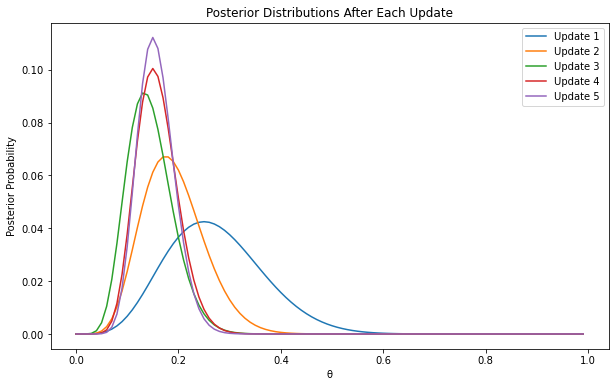

In [22]:
def plot_posteriors(dataset,p,prior):
    posteriors = bayes_update(dataset, p, prior)

    # Plot the posteriors
    plt.figure(figsize=(10, 6))
    for i, posterior_a in enumerate(posteriors):
        plt.plot(p, posterior_a, label=f'Update {i+1}')
    plt.xlabel('θ')
    plt.ylabel('Posterior Probability')
    plt.title('Posterior Distributions After Each Update')
    plt.legend()
    plt.show()
    
plot_posteriors(dataset,p,prior)

## 5. Piecewise uniform priors

Having developed a full workflow for tackling problems with bayesian inference let's explore non-uniform priors i.e. before any data is seen we have an opinion on what the bias may be. 

Consider the case where Bob, hands you a coin and says *'this coin is biased towards tails, but remember I lie x% of the time'* (i.e. $0 < p < 0.5$ x% of the time and $0.5<p<1$ (100-x)% of the time).

We can encode this by using a piecewise-uniform prior

$$\pi =  
\begin{cases} 
x/0.5, \qquad 0 < p < 0.5 \\
(1-x)/0.5, \quad 0.5 < p < 1
\end{cases}$$

Now lets repeat the above analysis using bayesian updating for a dataset consisting of 5 sets of 10 flips. In the first case, Bob wasn't lying and $p_\text{true} = 0.25$. In the second case, Bob was lying and $p_\text{true} = 0.75$. 

As expected when Bob isn't lying our graph converges towards $p_\text{true}$ normally. Interestingly, when Bob is lying, although after all 5 sets of flips the posterior looks closely matches that to when Bob is telling the truth. For the first and second posterior we get a bimodal distribution meaning we are not sure about whether to trust our data or our prior. 

This shows that for sparse data regimes, the choice of prior is important but for regimes where there is lots of data it is much less important. 

 

The two interesting cases to look at are when our prior guess is right, such that $p_{\mu} \approx p_{\text{true}}$ and when our prior is very wrong, so we have been tricked and were given a coin with bias very different to what we thought. 

![Non_Uniform_Bayes](figs/non_uniform.png)

In the bottom graph we see when our prior is right, each of the updated posteriors rapidly converges to the true value, with a more spiked (confident) distribution. However, when we have been tricked and our prior is very wrong, the posteriors are 'dragged' away from our prior as more and more data flows in. This reflects the balance between our initial opinion that a coin with $p_{\text{true}}=0.1$ is very unlikely, combined with the fact that we keep flipping tails over and over. It is interesting to see that even for only $N=100$ flips total, the posterior has moved significantly away from the initial prior.

Choosing a good prior can become very important when working with more complicated models. For example, in a 100-dimensional bayesian inference, the volume of posterior space to explore becomes huge and the process of converging our prior onto the true posterior becomes exponentially slower. Therefore choosing a prior which is accurate can drastically reduce the amount of data and computational resources required.